Nolan Roth <br>
PHYS 434 AC

# Lab #7

In [26]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import pickle
import h5py
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 10)

In [27]:
infile = open ('higgs_250_500.pkl','rb')
higgs_data = pickle.load(infile)
infile = open ('qcd_250_500.pkl', 'rb')
qcd_data = pickle.load(infile)

In [28]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

Making a stacked histogram for Higgs mass data versus QCD mass data: 

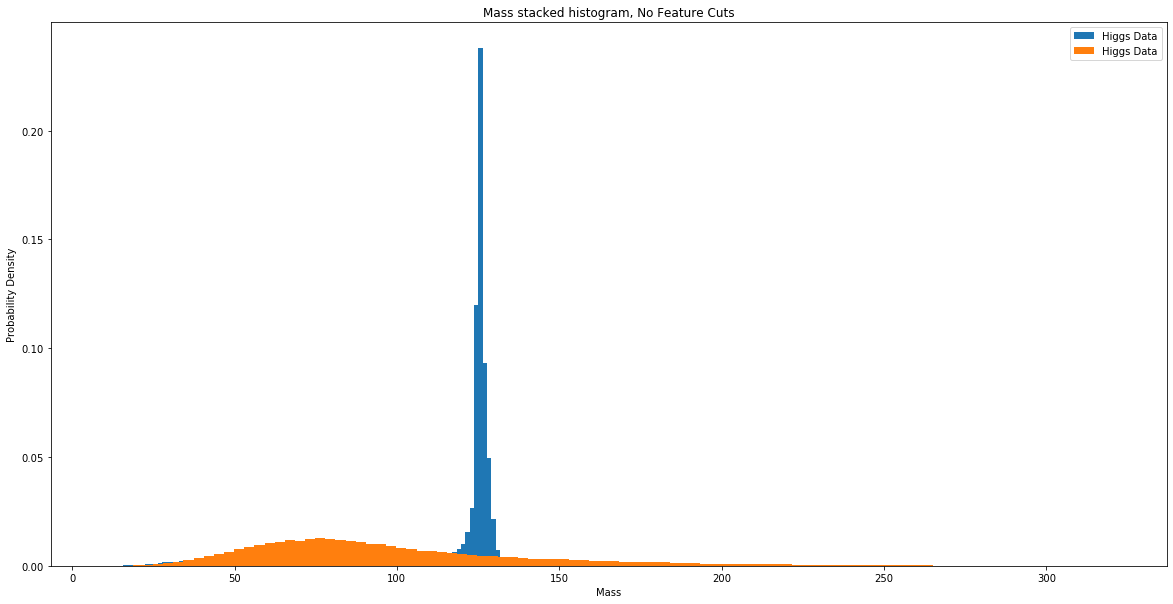

In [29]:
plt.hist(higgs_data['mass'], 100, density=True, label='Higgs Data')
plt.hist(qcd_data['mass'], 100, density=True, label='Higgs Data')
plt.title('Mass stacked histogram, No Feature Cuts')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [30]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

Calculating the significance without any mass cuts:

In [31]:
total_events = len(higgs_events) + len(qcd_events)
normalized_higgs = 100
normalized_qcd = 20000
print('Significance without any cuts: ' + str(stats.norm.ppf(stats.poisson.cdf(normalized_higgs + normalized_qcd, normalized_qcd))))
print('N(Higgs) / sqrt(N(QCD)) = ' + str(normalized_higgs/(normalized_qcd)**(1/2)))

Significance without any cuts: 0.7112259282313185
N(Higgs) / sqrt(N(QCD)) = 0.7071067811865475


The significance value is very close to the value of N(Higgs) / sqrt(N(QCD)).

## Problem 2

In [32]:
def makeCut(lower, upper):
    cut_higgs_indices = []
    cut_qcd_indices = []
    # storing indices of data points with mass between upper and lower
    for i in range(0, len(higgs_events)):
        if higgs_events[i] >= lower and higgs_events[i] <= upper:
            cut_higgs_indices.append(i)
    for j in range(0, len(qcd_events)):
        if qcd_events[j] >= lower and qcd_events[j] <= upper:
            cut_qcd_indices.append(j)
    total_events = len(higgs_events) + len(qcd_events)
    normalized_higgs = 2 * 100 * (len(cut_higgs_indices) / total_events)
    normalized_qcd = 2 * 20000 * (len(cut_qcd_indices) / total_events)
    # multiplying the above values by 2 to account for the fact that when the counts are equal they
    # should be normalized to 100 and 20,000, not 50 and 10,000
    return [normalized_higgs, normalized_qcd, cut_higgs_indices, cut_qcd_indices]

Going forwards from 0 to 140 to find the optimal minimum for a mass cut:

In [33]:
max_sig = 0
max_lower = 0
for i in range(0, 140):
    x = makeCut(i, 140)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i
print(max_sig)
print(max_lower)

1.9323875707620133
123


Going backwards from 140 to 124 to find the optimal maximum for a mass cut:

In [13]:
max_sig = 0
max_upper = 140
for i in range(0, 140 - max_lower):
    x = makeCut(max_lower, 140 - i)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i
print(max_sig)
print(max_upper)

2.8645980478035016
128


So the optimal mass cut to maximize discovery significance is from 123 to 128.

In [38]:
temp = makeCut(123, 128)
mass_cut_higgs_indices = temp[2]
mass_cut_qcd_indices = temp[3]

## Problem 3

Stacked histograms for the rest of the variables:

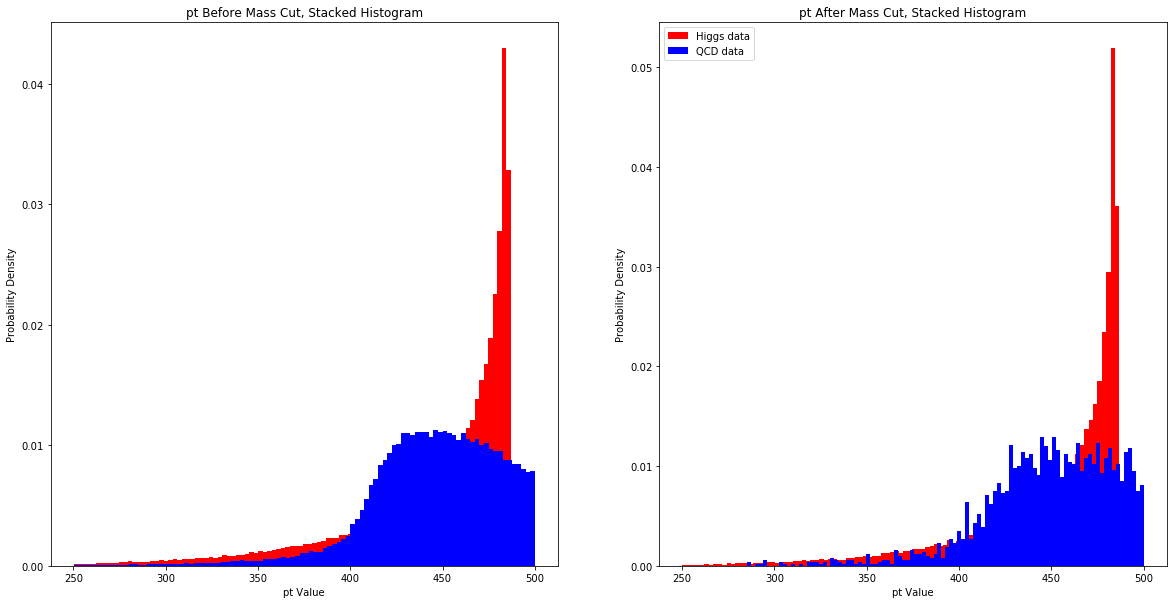

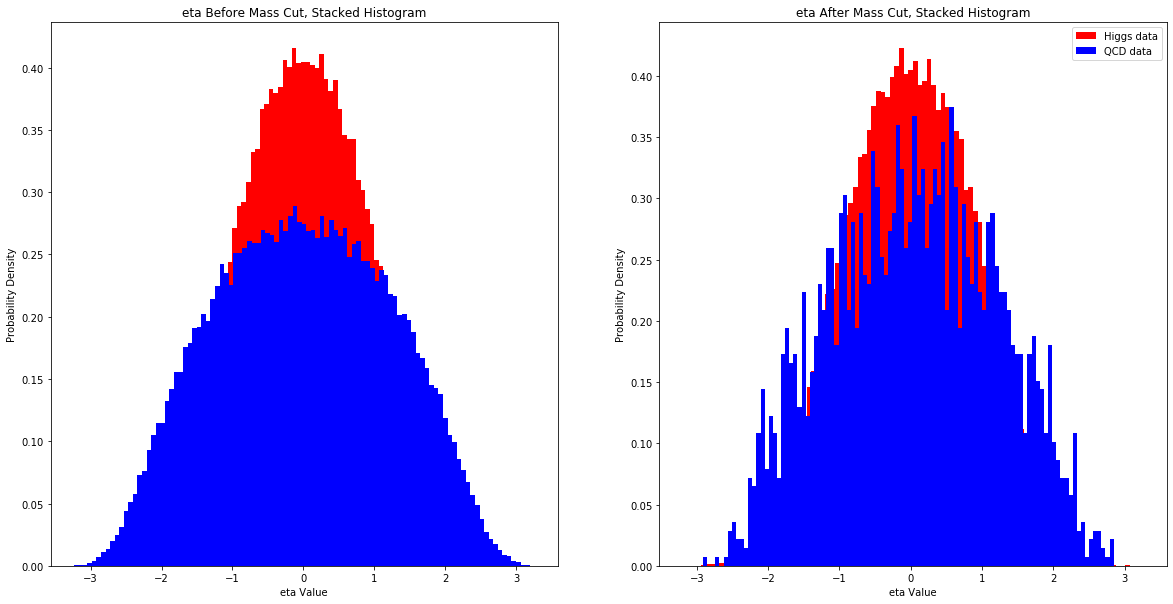

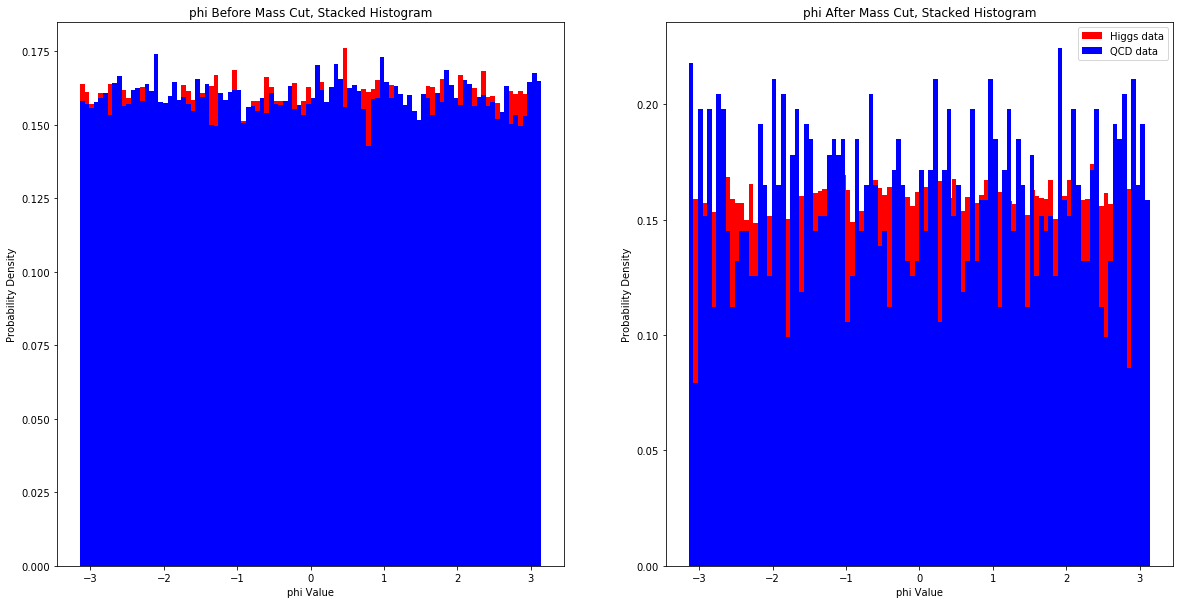

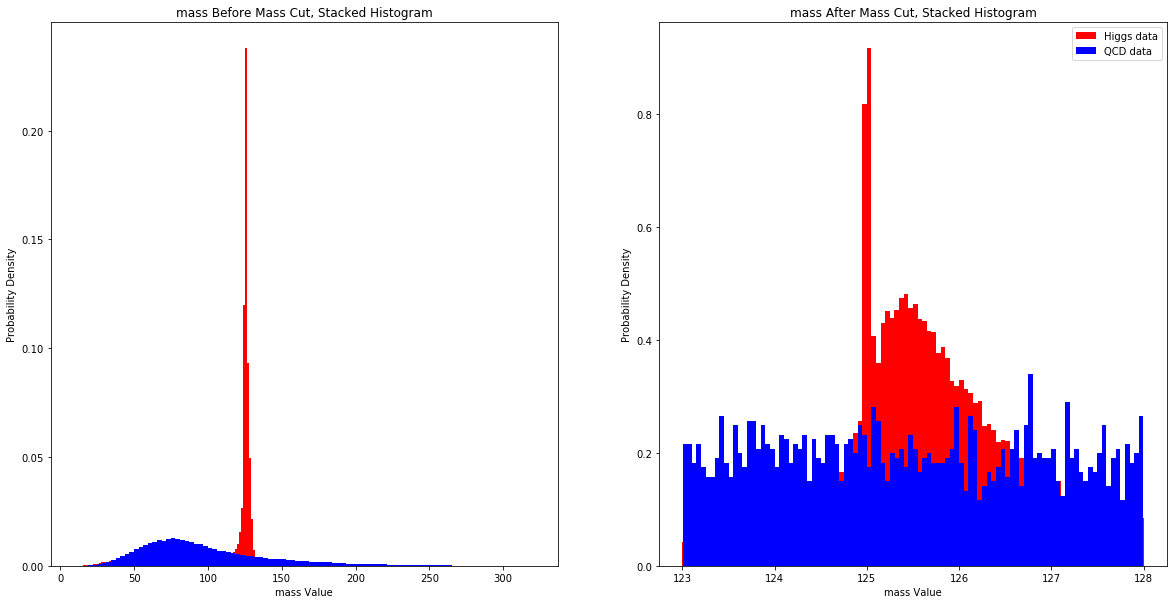

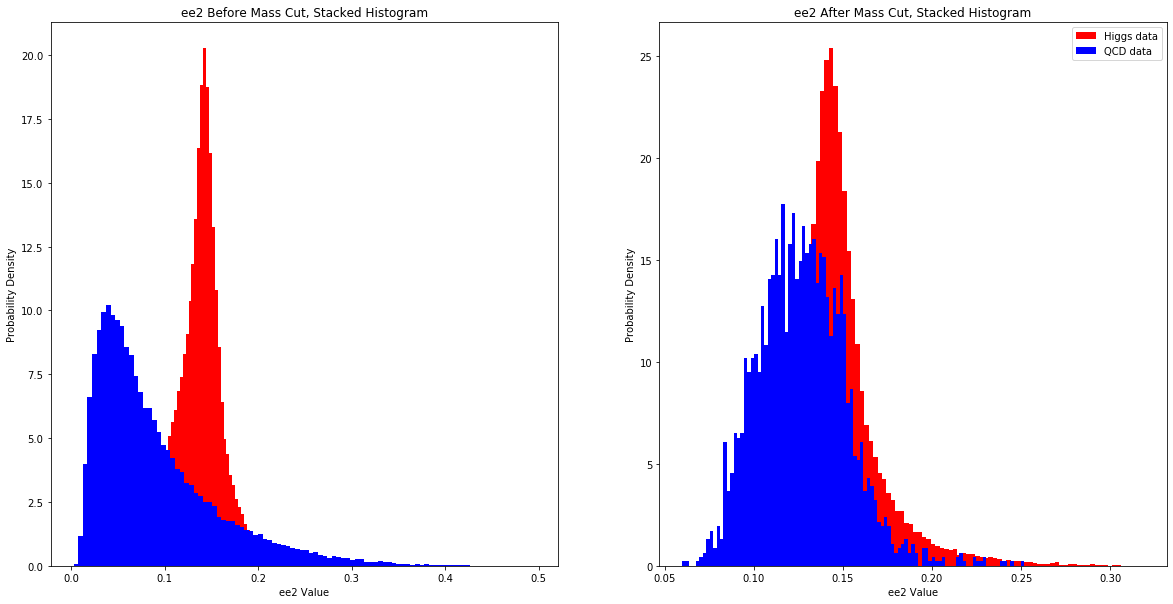

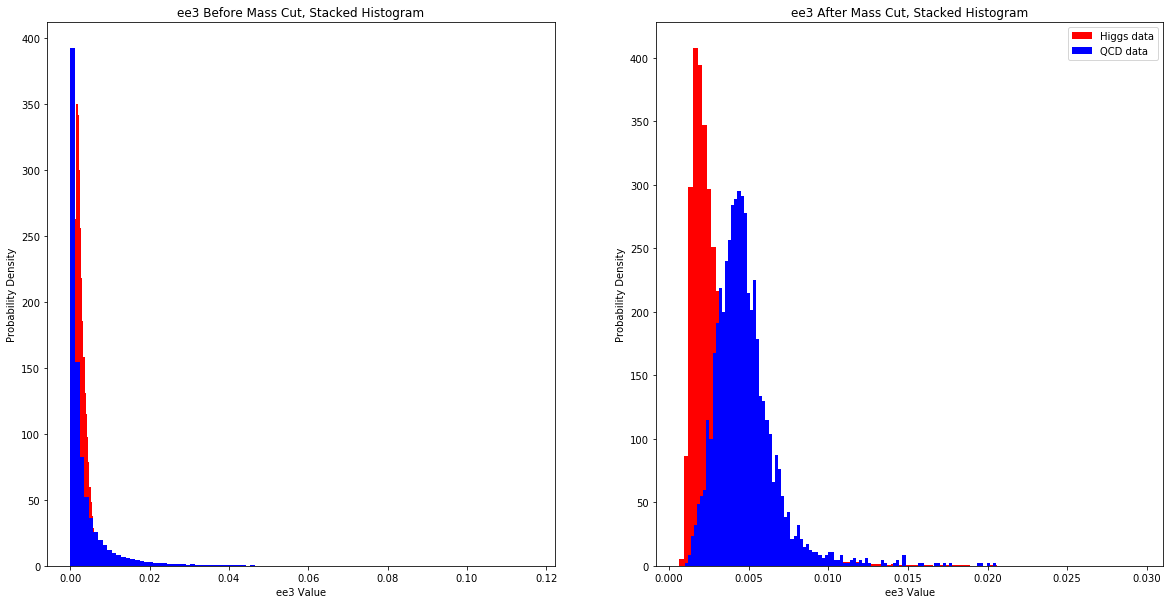

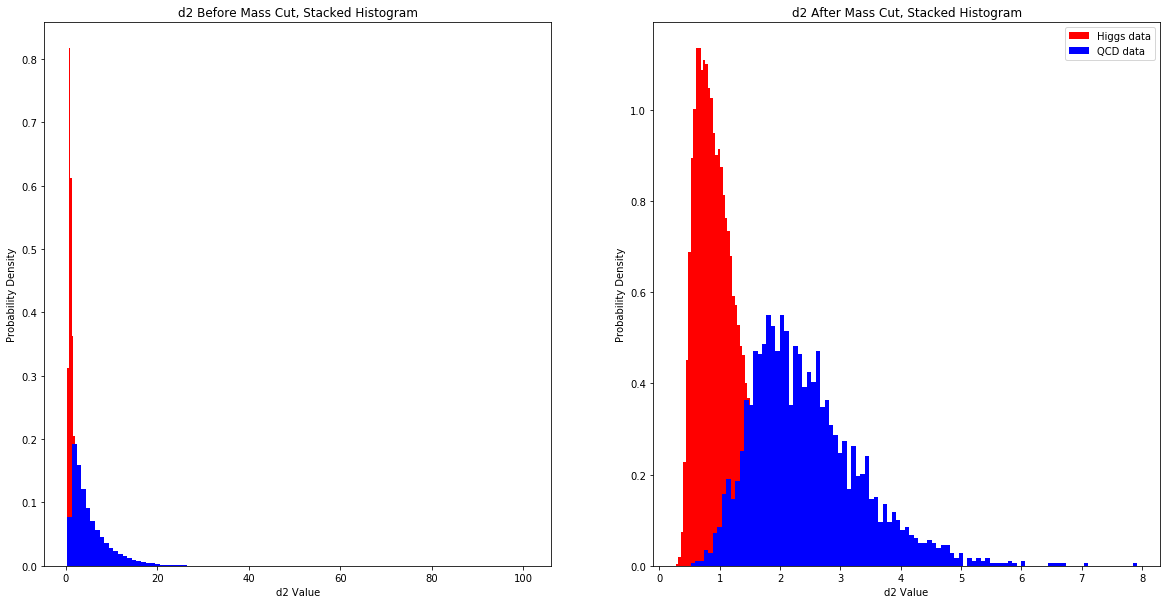

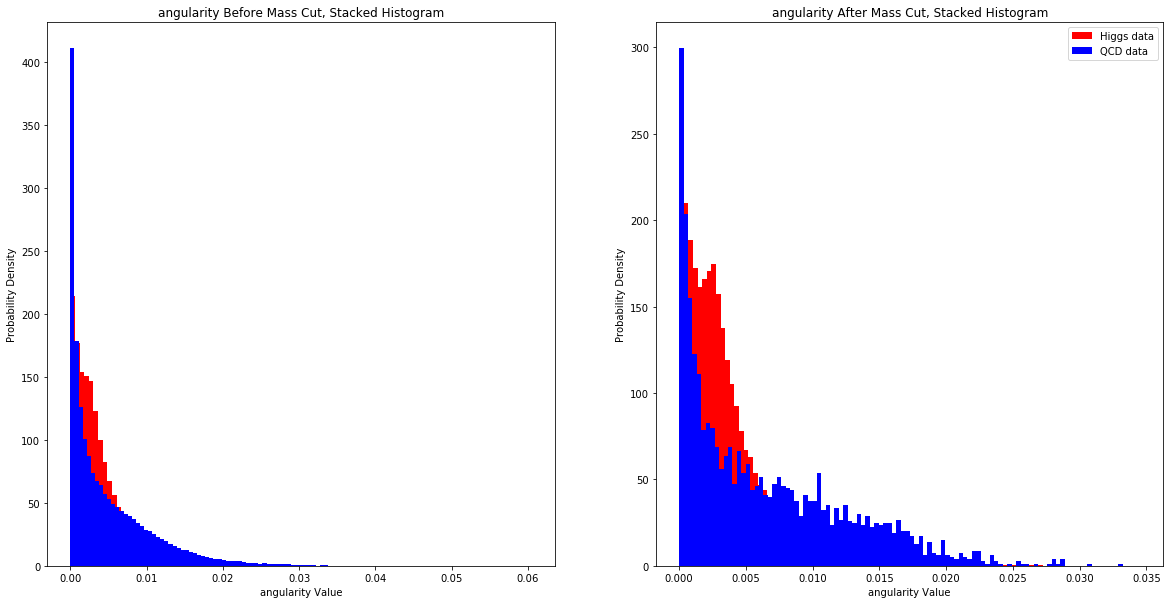

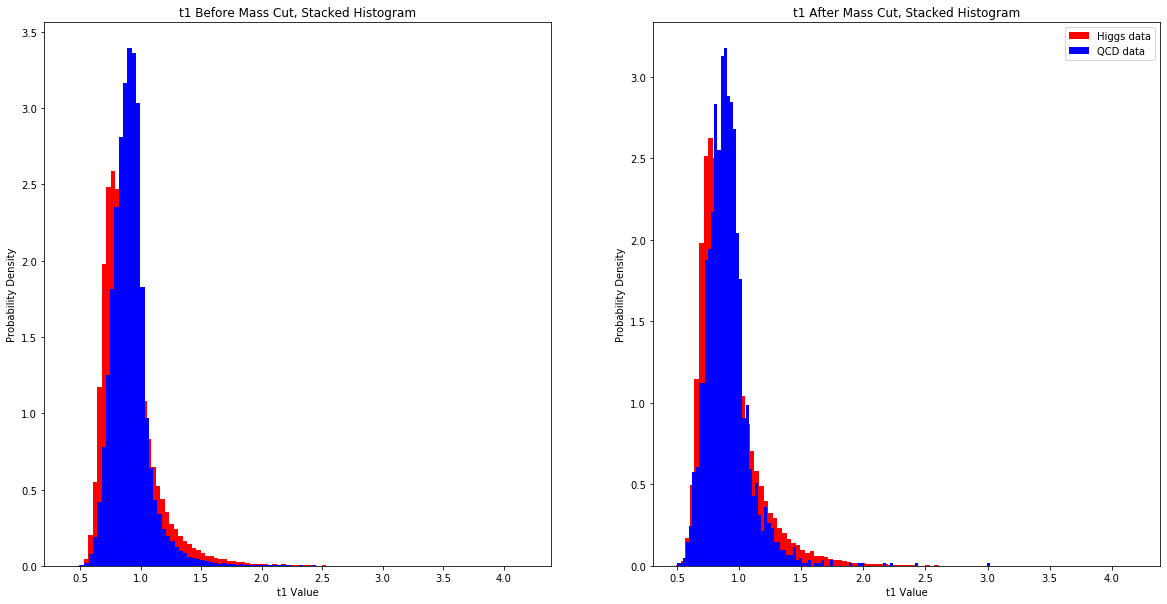

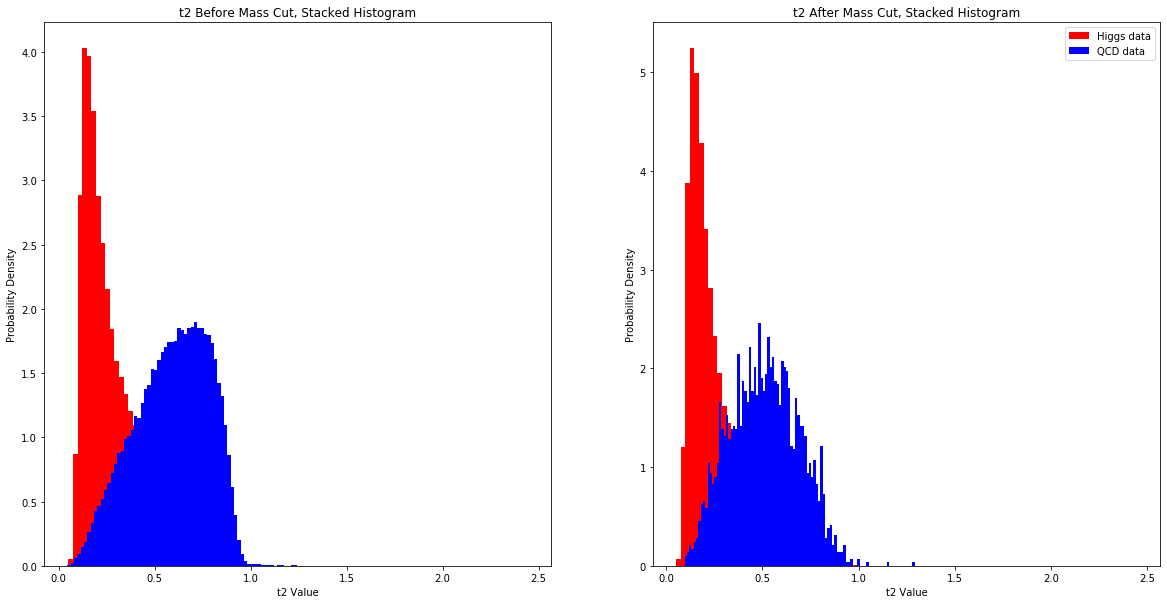

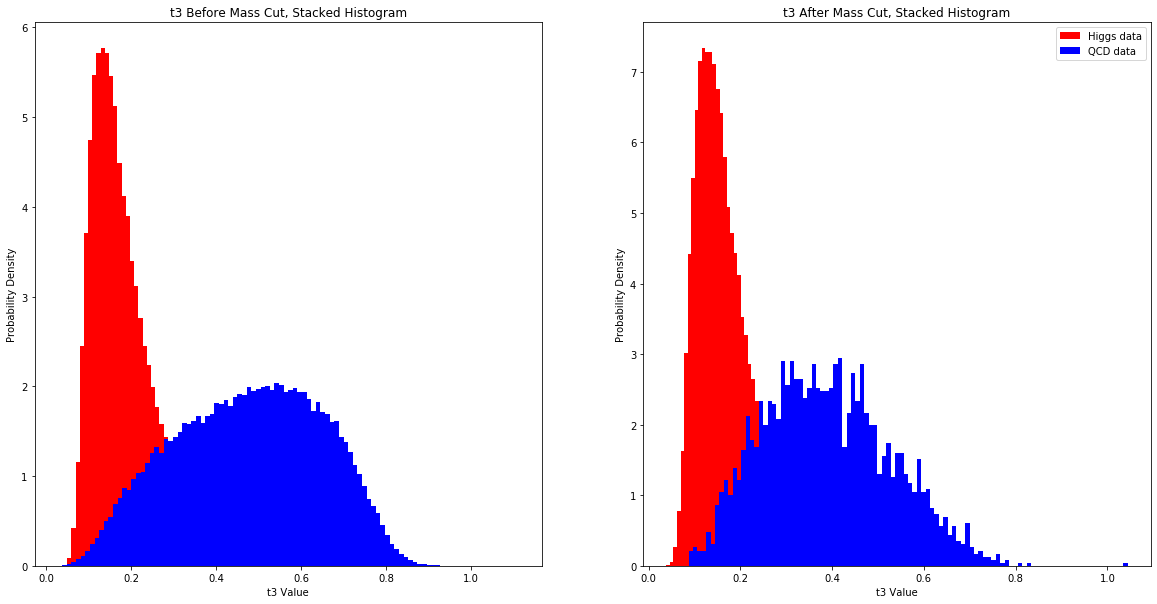

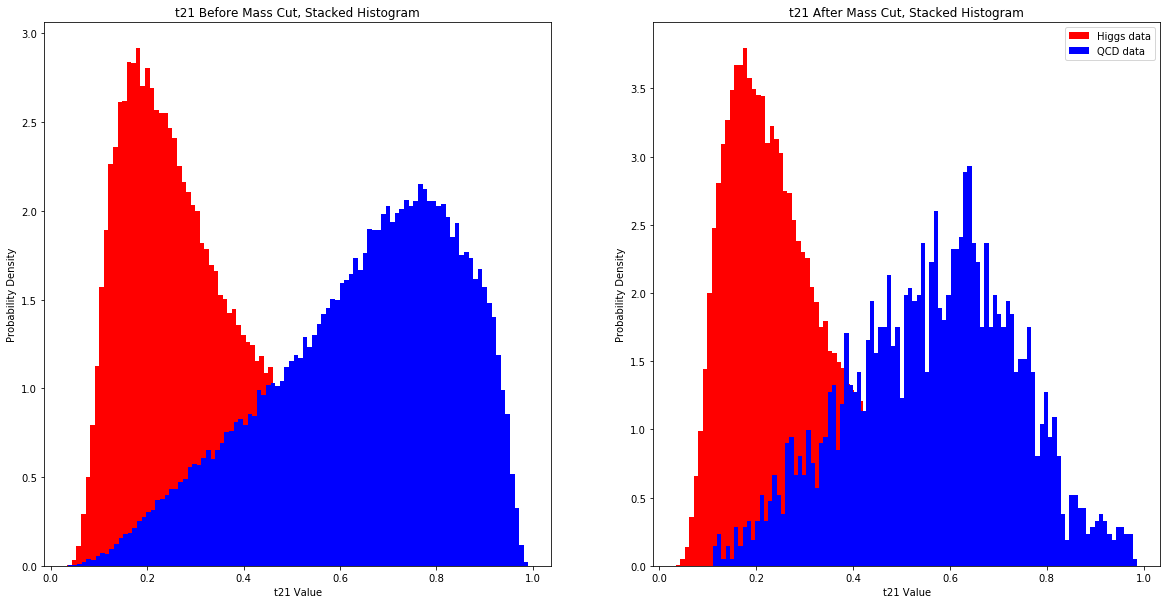

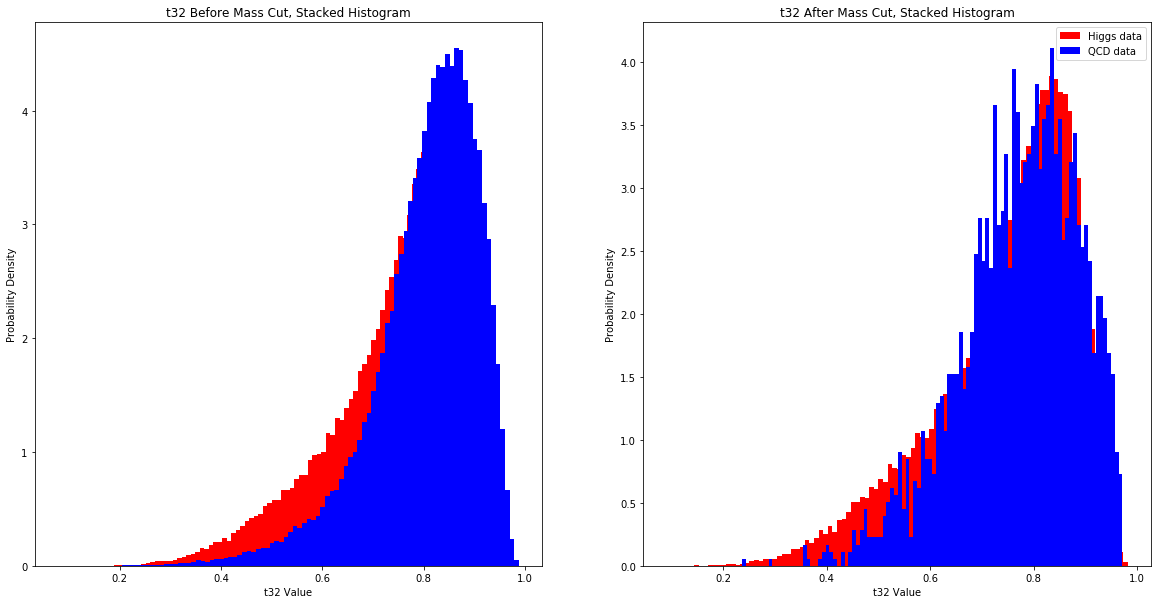

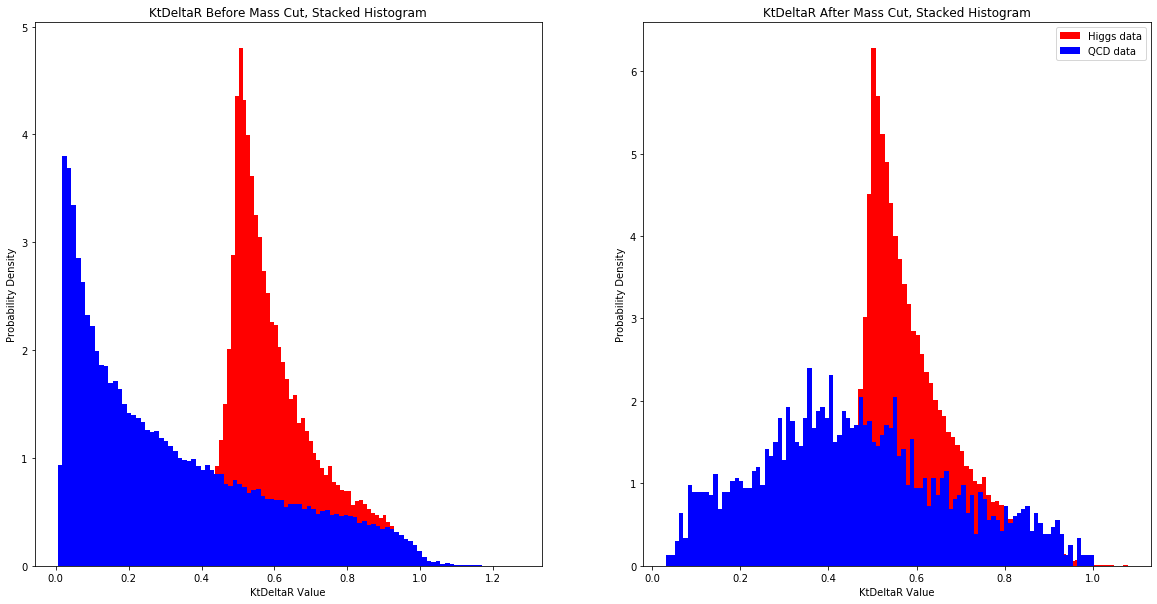

In [34]:
for key in higgs_data.keys():
    higgs_vals = []
    qcd_vals = []
    for i in range(0, len(mass_cut_higgs_indices)):
        higgs_vals.append(higgs_data[key][mass_cut_higgs_indices[i]])
    for j in range(0, len(mass_cut_qcd_indices)):
        qcd_vals.append(qcd_data[key][mass_cut_qcd_indices[j]])
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='r', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    ax1.set_title(str(key) + ' Before Mass Cut, Stacked Histogram')
    ax2.set_title(str(key) + ' After Mass Cut, Stacked Histogram')
    ax1.set_xlabel(str(key) + ' Value')
    ax2.set_xlabel(str(key) + ' Value')
    ax1.set_ylabel('Probability Density')
    ax2.set_ylabel('Probability Density')
    plt.legend()
    plt.show()

## Problem 4

In [18]:
higgs_temp = higgs_data['t3'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t3'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [19]:
def findLower(lower, upper):
    max_sig = 0
    max_lower = lower
    for i in np.arange(0.0, upper, (upper - lower) / 20):
        higgs_count = makeCut(i, upper)[0]
        qcd_count = makeCut(i, upper)[1]
        #norm_higgs = makeCut(i, upper)[0]
        #norm_qcd = makeCut(i, upper)[1]
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig:
            max_sig = sig
            max_lower = i
    print(max_sig)
    print(max_lower)

In [20]:
def findUpper(lower, upper):
    max_sig = 0
    max_upper = upper
    for i in np.linspace(0.0, upper - lower, 20, endpoint=False):
        higgs_count = makeCut(lower, upper - i)[0]
        qcd_count = makeCut(lower, upper - i)[1]
        #norm_higgs = makeCut(lower, upper - i)[0]
        #norm_qcd = makeCut(lower, upper - i)[1]
        #sig = normalized_higgs/(normalized_qcd)**(1/2)
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig:
            max_sig = sig
            max_upper = upper - i
    print(max_sig)
    print(max_upper)

In [21]:
findLower(0.0, 0.7)

0.7391839989587543
0.0


In [22]:
findUpper(0.0, 0.7)

1.7203261835080887
0.17500000000000004


In [45]:
mass_cut_higgs_t3 = higgs_data['t3'][mass_cut_higgs_indices]
mass_cut_qcd_t3 = higgs_data['t3'][mass_cut_qcd_indices]

In [46]:
higgs_temp = mass_cut_higgs_t3.values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = mass_cut_qcd_t3.values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [47]:
temp = makeCut(0.0, 0.7)
t3_cut_higgs_indices = temp[2]
t3_cut_qcd_indices = temp[3]
print(len(t3_cut_higgs_indices))
print(len(t3_cut_qcd_indices))

ZeroDivisionError: division by zero

So right now we got the mass cut working but the second cut which is t3 is returning a super low upper bound with infinite ignificance and 0 values in that range, need to figure out how to make it use limits with actual values in there

So optimal t3 cut is from 0.05 to 0.1 with a significance of 4.446

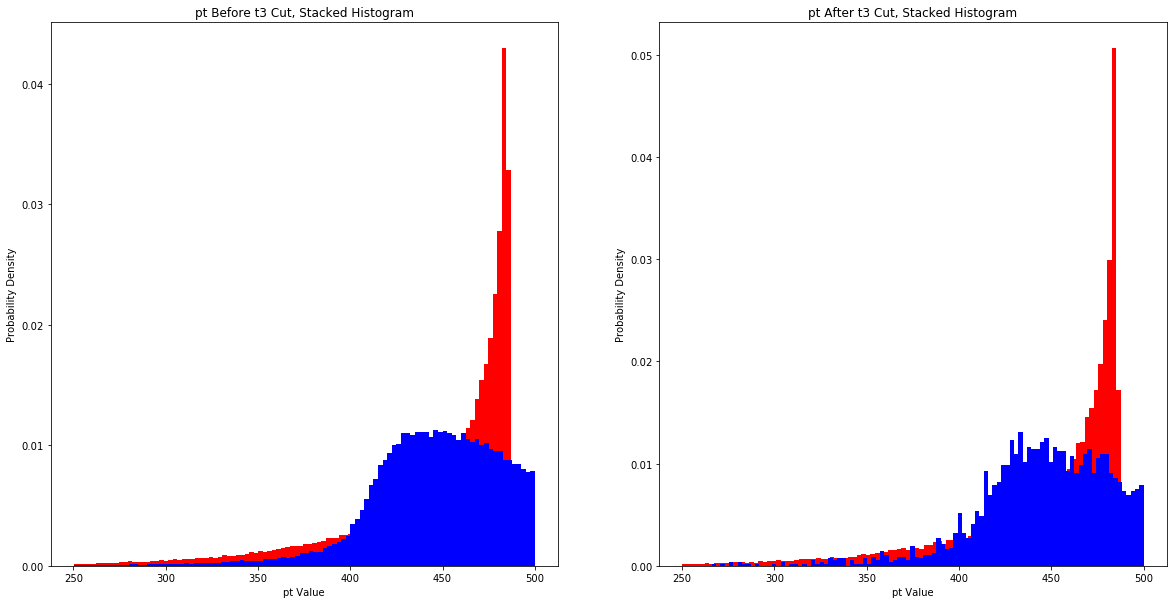

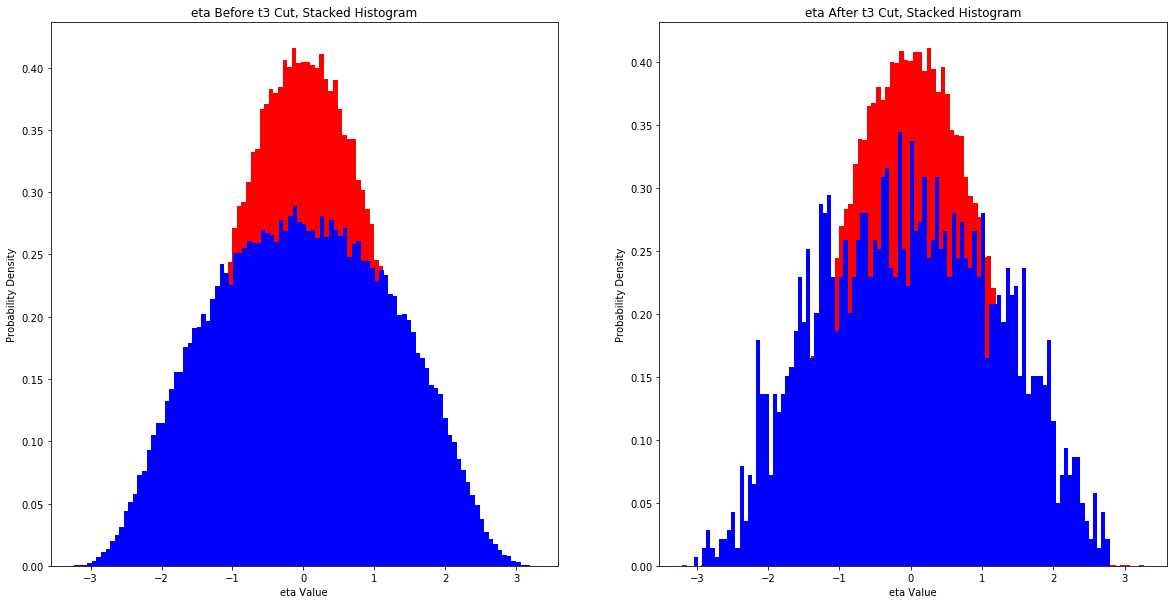

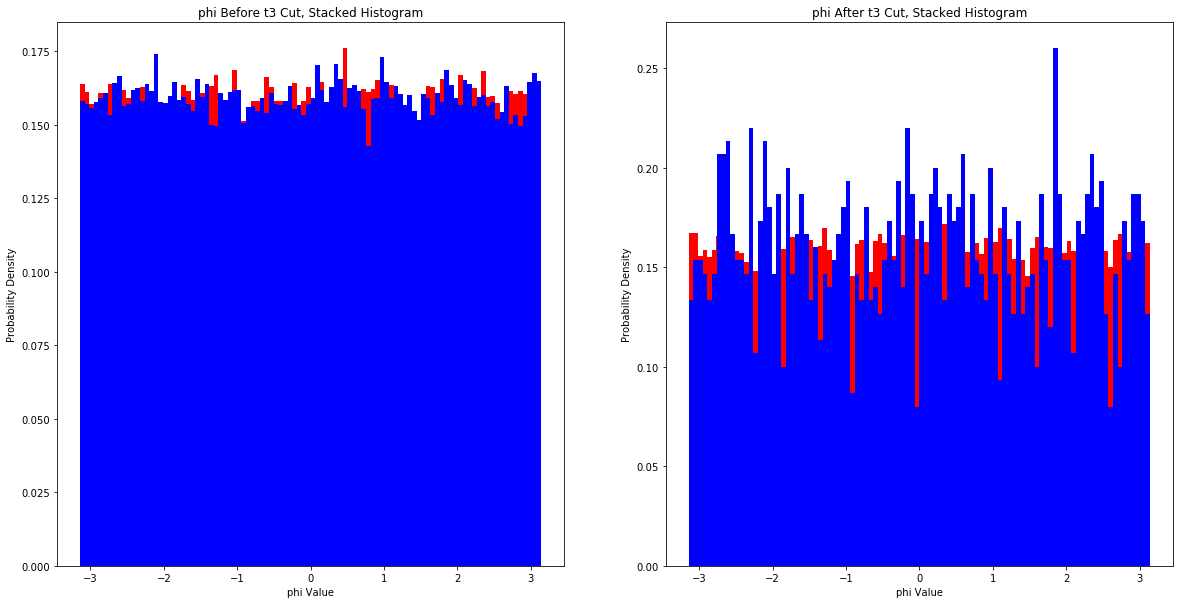

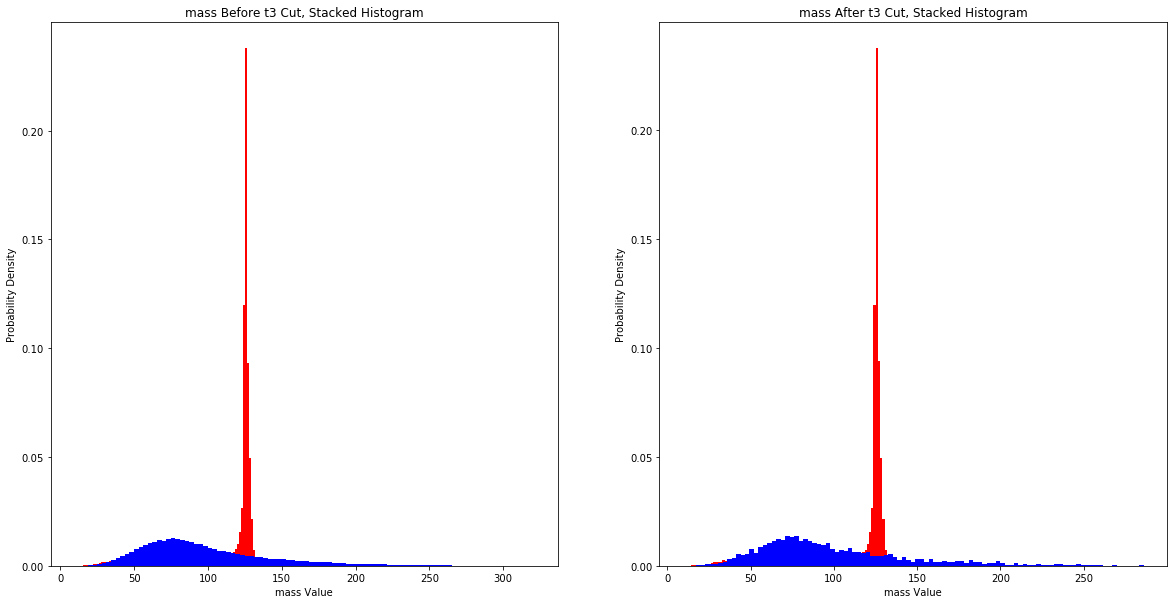

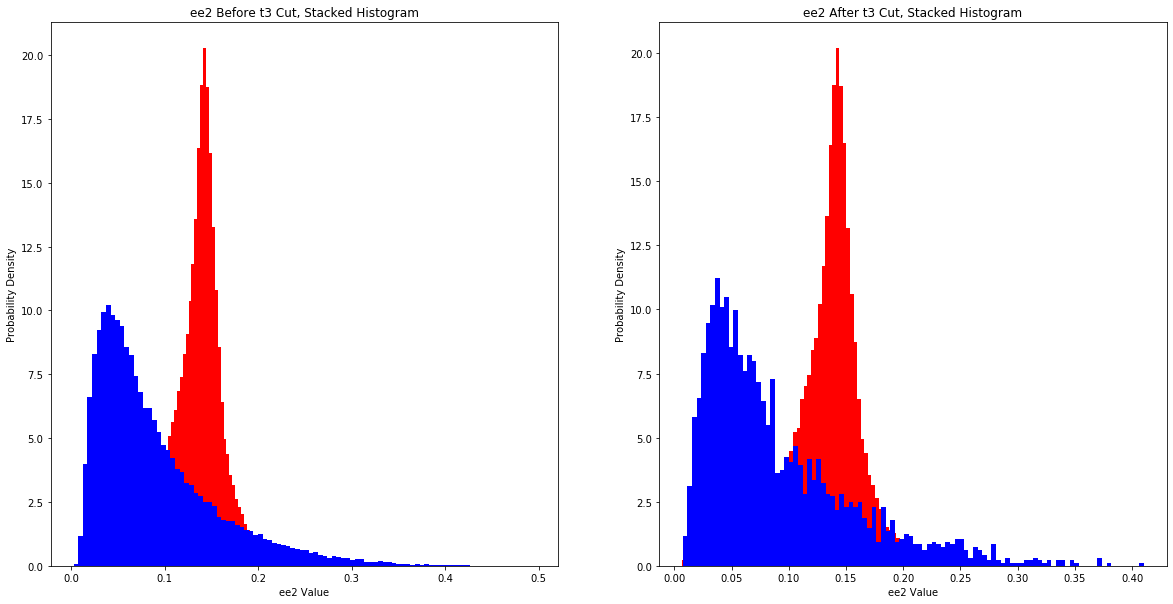

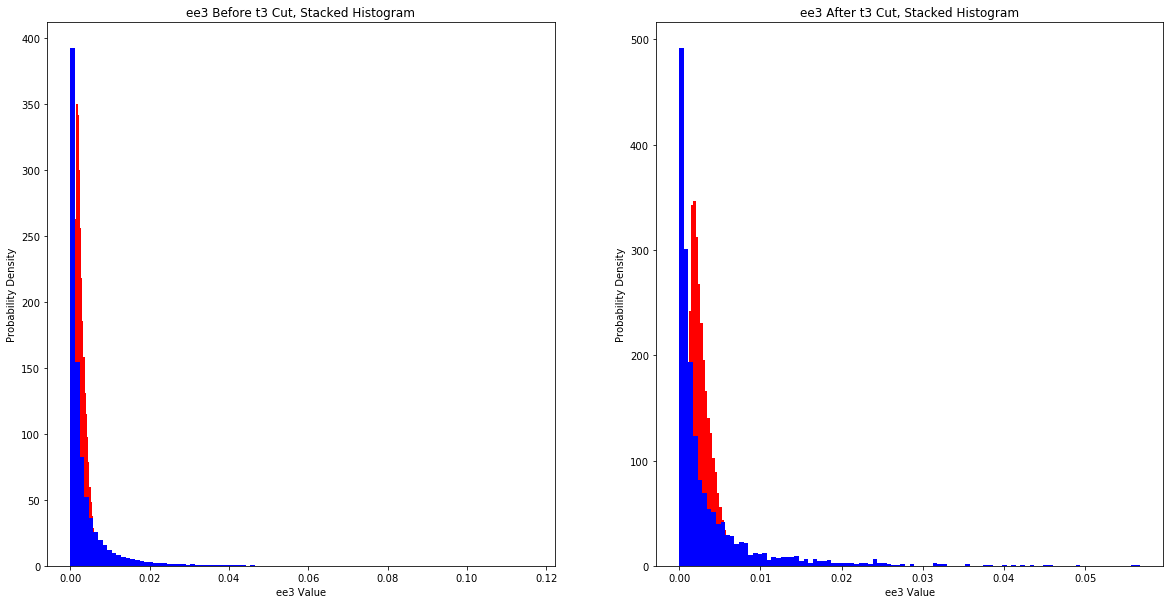

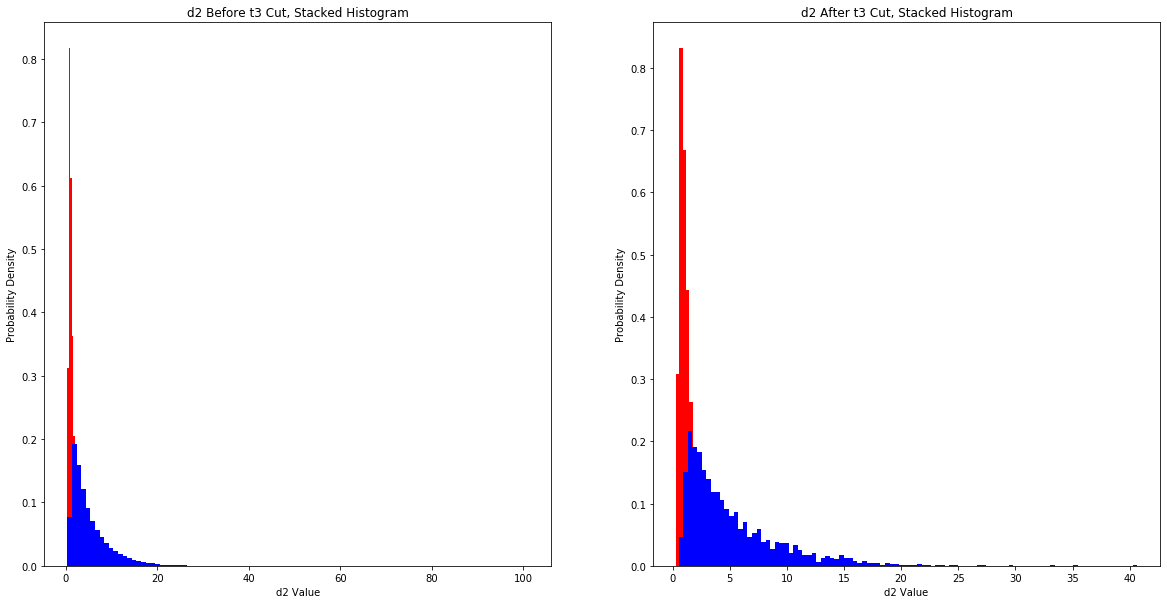

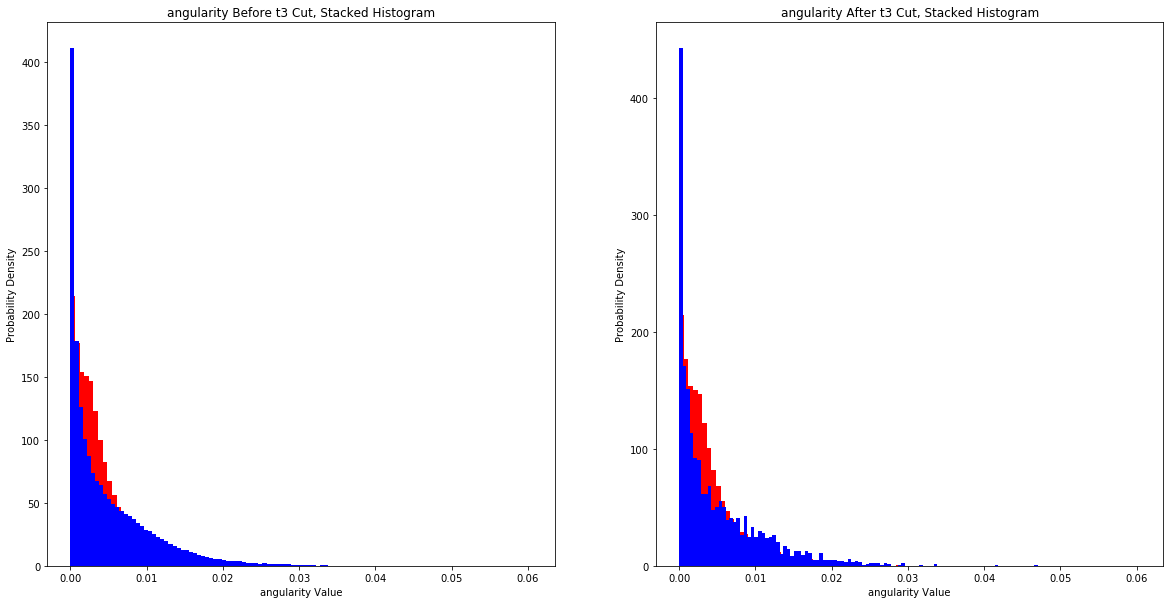

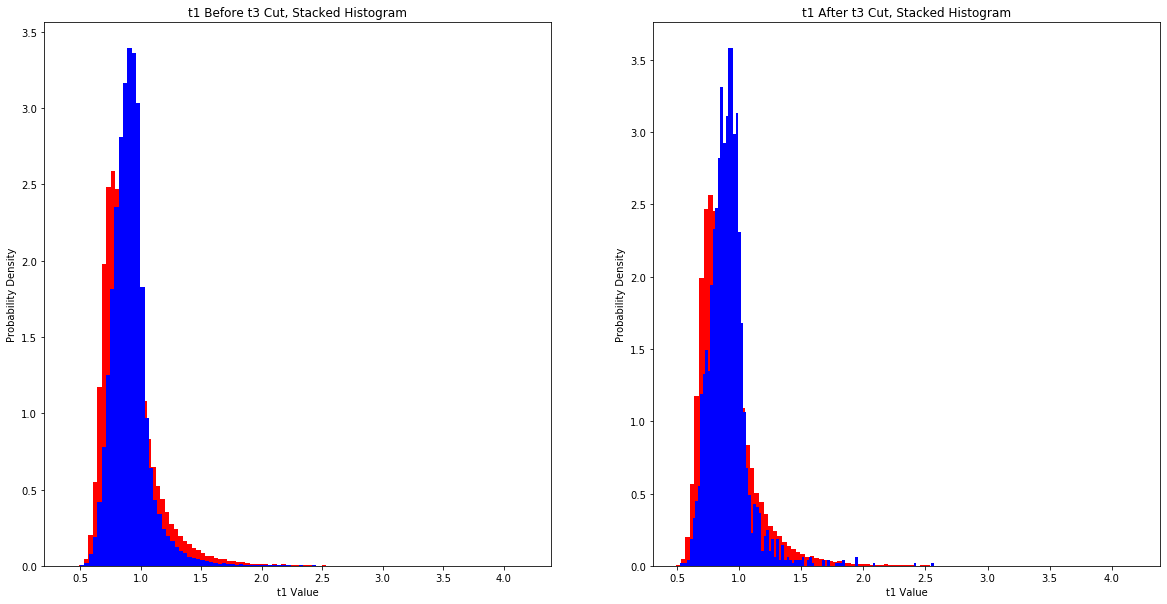

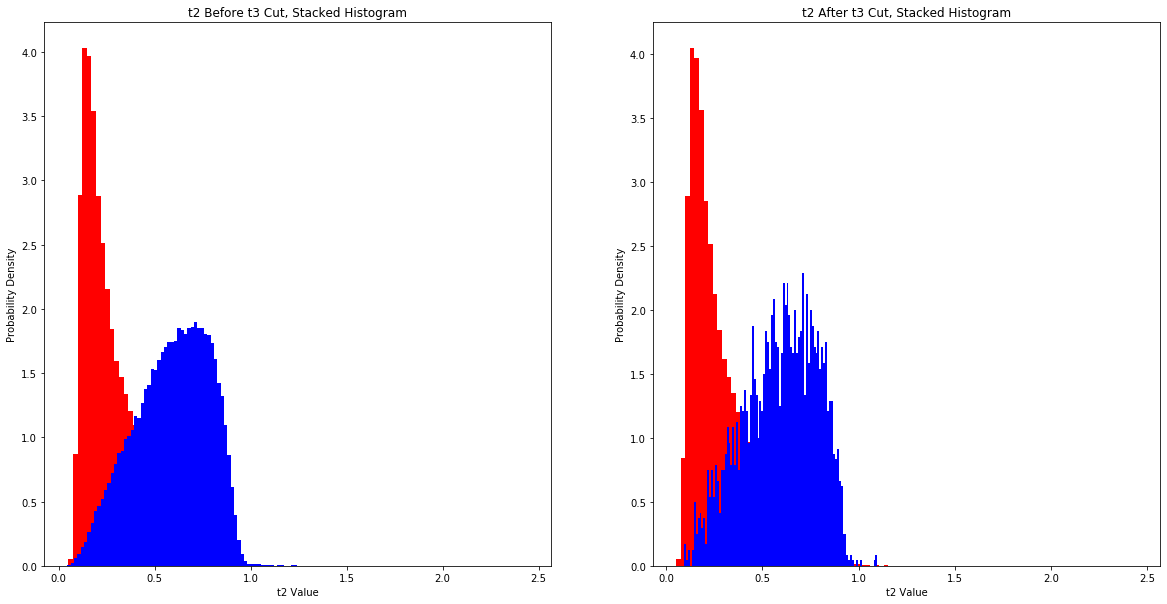

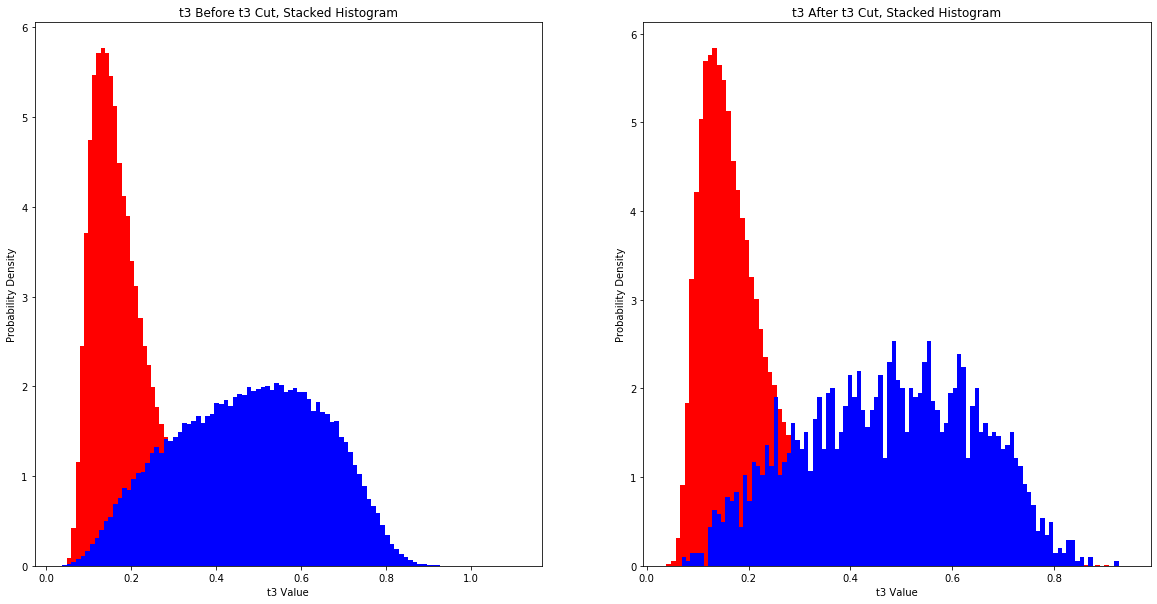

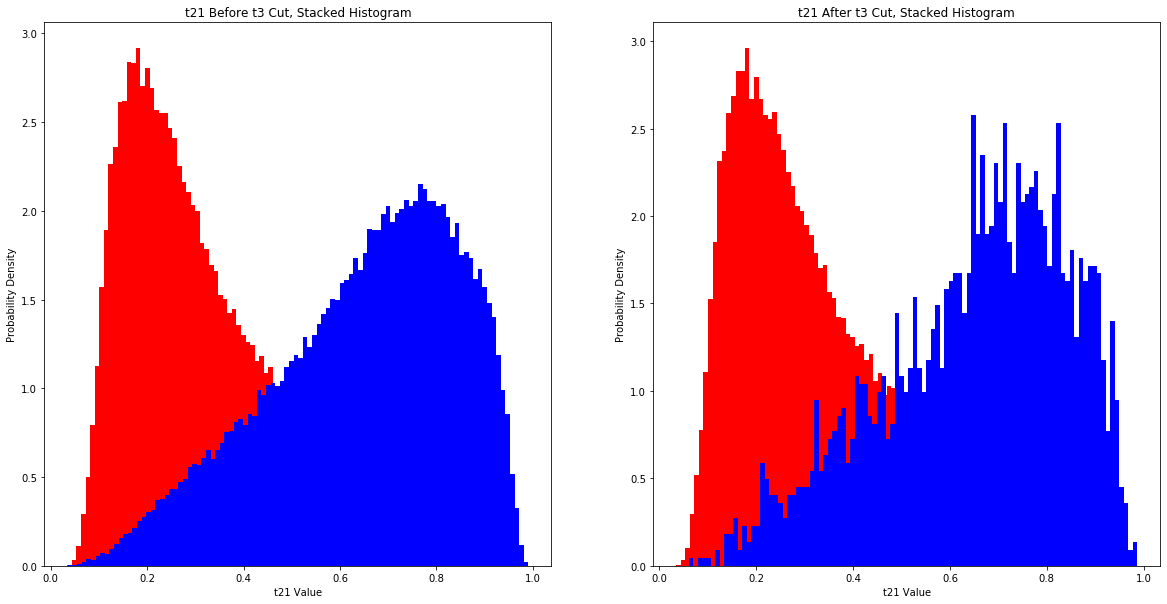

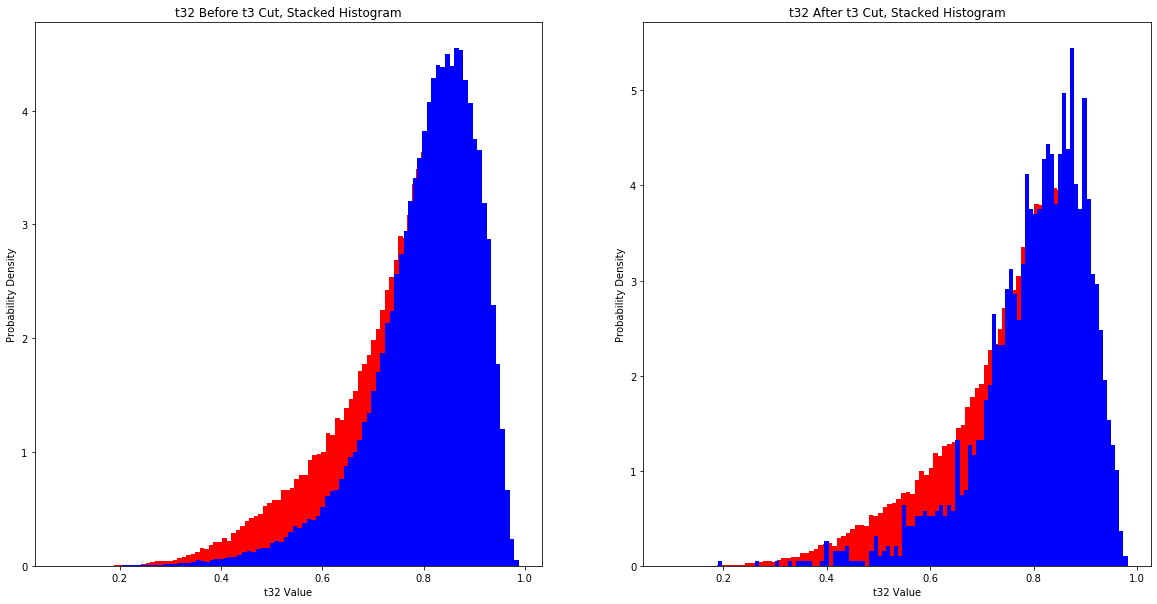

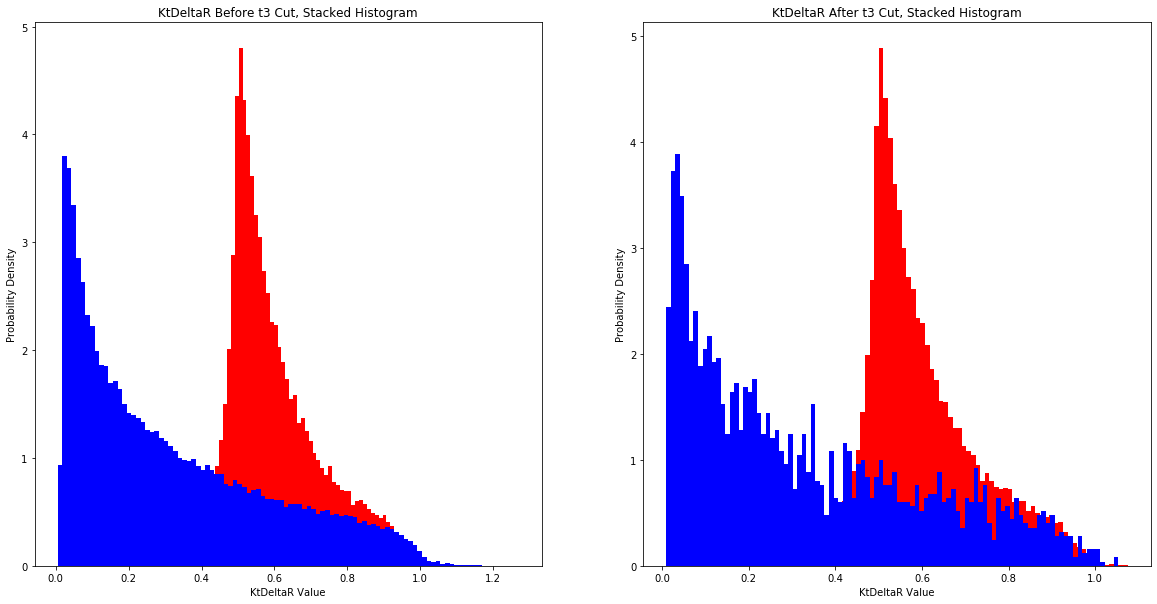

In [43]:
for key in higgs_data.keys():
    higgs_vals = []
    qcd_vals = []
    for i in range(0, len(t3_cut_higgs_indices)):
        higgs_vals.append(higgs_data[key][t3_cut_higgs_indices[i]])
    for j in range(0, len(t3_cut_qcd_indices)):
        qcd_vals.append(qcd_data[key][t3_cut_qcd_indices[j]])
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='r', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    ax1.set_title(str(key) + ' Before t3 Cut, Stacked Histogram')
    ax2.set_title(str(key) + ' After t3 Cut, Stacked Histogram')
    ax1.set_xlabel(str(key) + ' Value')
    ax2.set_xlabel(str(key) + ' Value')
    ax1.set_ylabel('Probability Density')
    ax2.set_ylabel('Probability Density')
    plt.show()

# Lab #8

In [6]:
high_lumi_data = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lumi_data = pd.read_hdf('data_lowLumi_pt_250_500.h5')

In [7]:
high_lumi_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [8]:
low_lumi_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

In [12]:
high_lumi_masses = np.array(high_lumi_data.get('mass'))
low_lumi_masses = np.array(low_lumi_data.get('mass'))

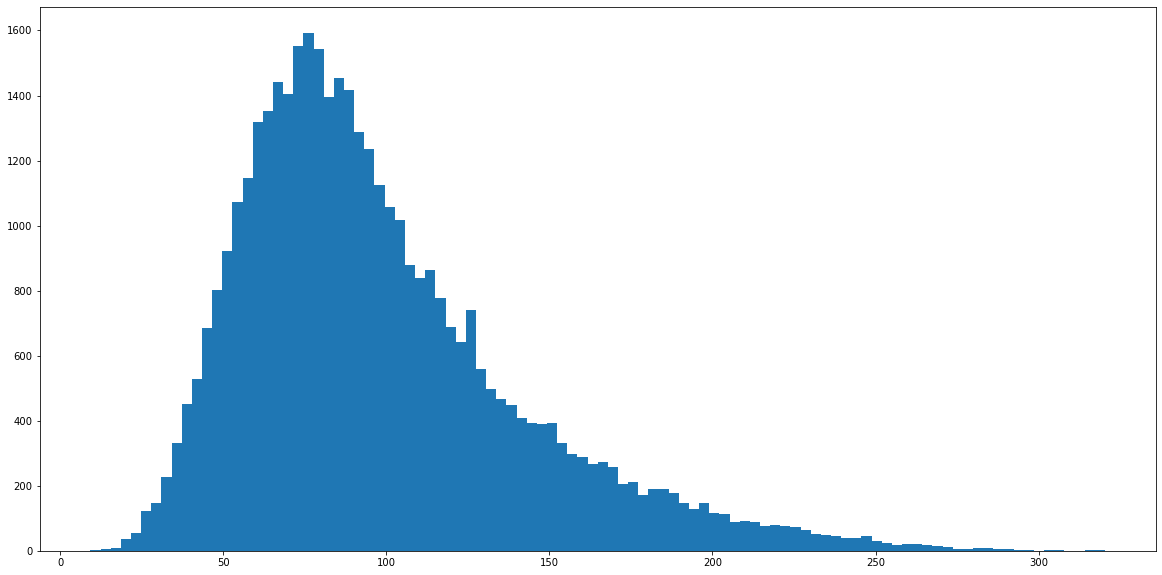

In [13]:
plt.hist(high_lumi_masses, 100, density=True)
plt.hist()
plt.show()

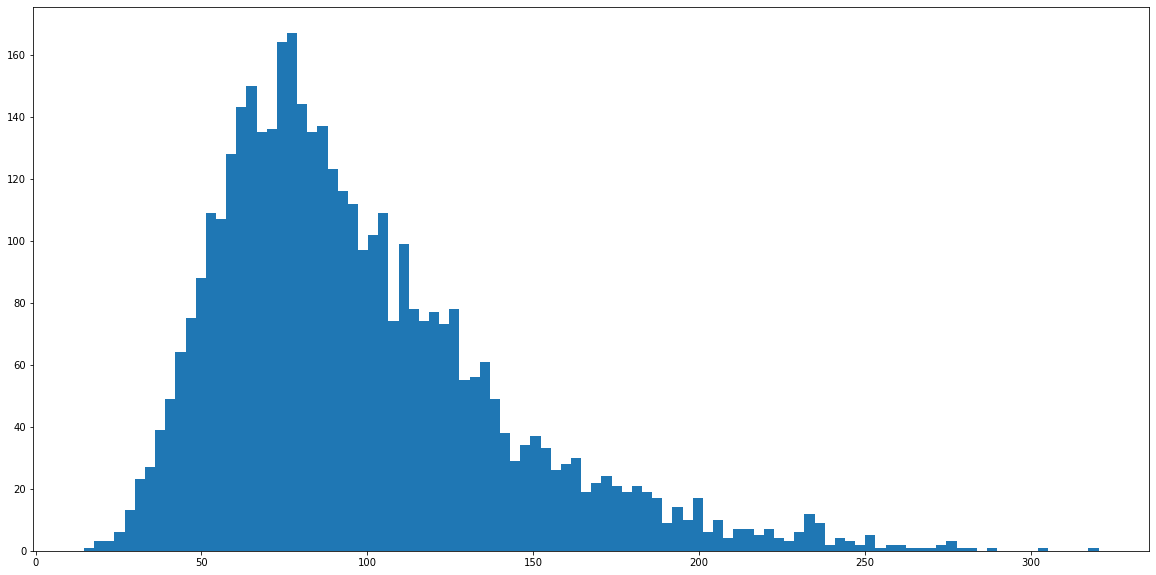

In [165]:
plt.hist(low_lumi_masses, 100)
plt.show()

In [14]:
def makeCut1(lower, upper, vals):
    cut_indices = []
    for i in range(0, len(vals)):
        if vals[i] >= lower and vals[i] <= upper:
            cut_indices.append(i)
    return cut_indices

In [57]:
mass_cut_high_indices = makeCut1(123, 128, high_lumi_masses)
high_cut_masses = high_lumi_masses[mass_cut_high_indices]
higgs_cut_masses = higgs_events[mass_cut_higgs_indices]
qcd_cut_masses = qcd_events[mass_cut_qcd_indices]

[125.89410185 125.00176204 124.66810799 ... 123.78531357 127.41069987
 125.64575417]


In [58]:
print(len(hi_cut_masses))
print(len(higgs_cut_masses))
print(len(qcd_cut_masses))

1122
63895
2412


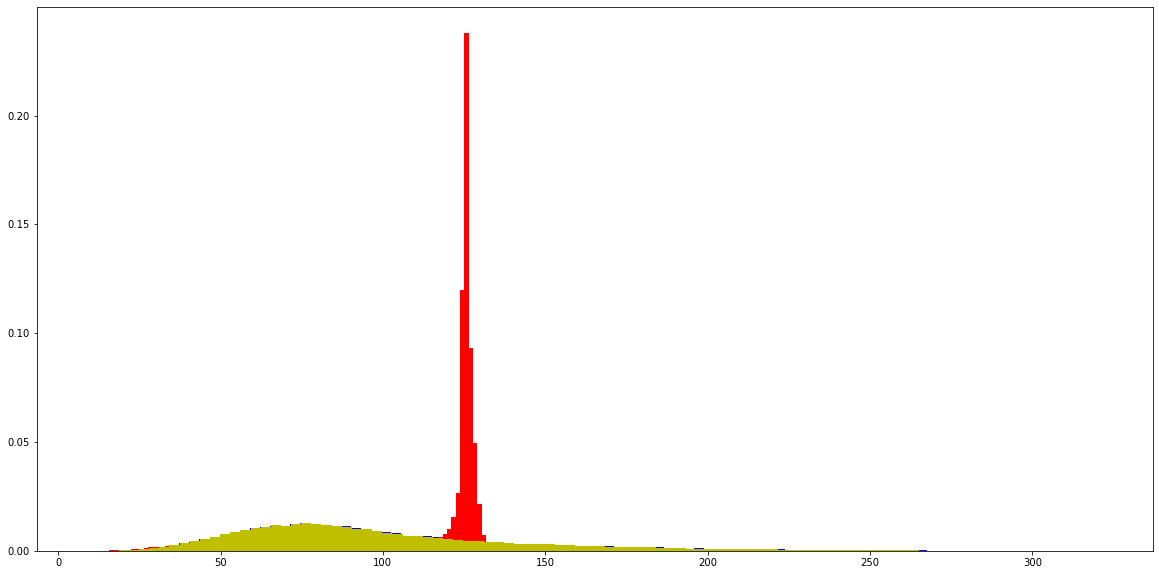

In [27]:
plt.hist(high_lumi_masses, 100, density=True, color='b')
plt.hist(higgs_data['mass'], 100, density=True, color='r')
plt.hist(qcd_data['mass'], 100, density=True, color='y')
plt.show()

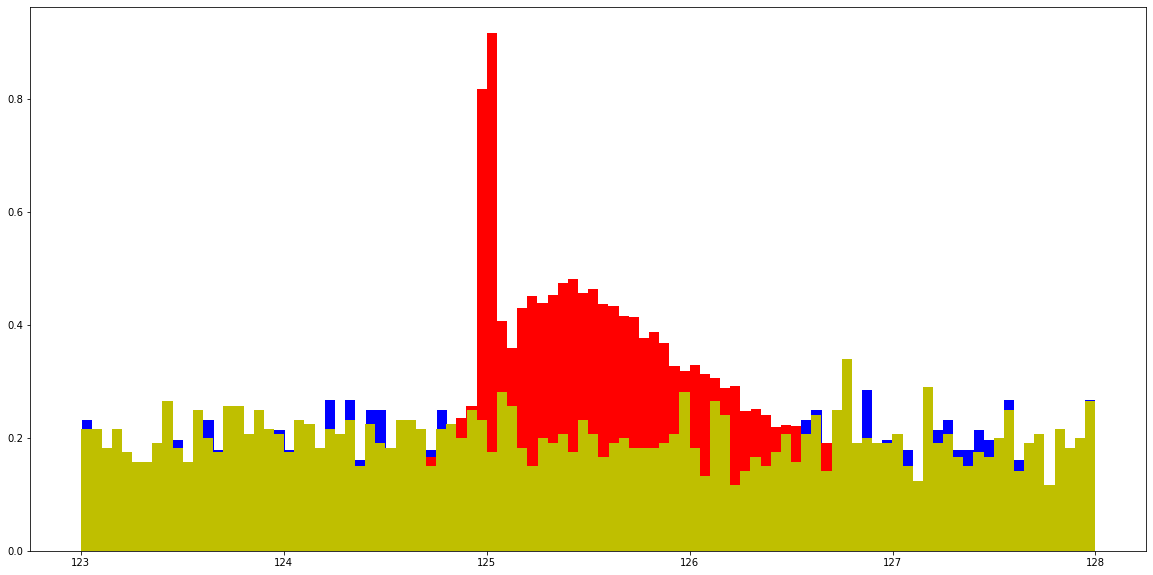

In [61]:
plt.hist(high_cut_masses, 100, density=True, color='b')
plt.hist(higgs_cut_masses, 100, density=True, color='r')
plt.hist(qcd_cut_masses, 100, density=True, color='y')
plt.show()